# Import libraries

* Use just one year (e.g. 2019)
* Train on 70 %, test on 30 % of the data 
* Random forests (classification)

* two classes
* decrease class means > -10%
* no change class is between -5 and 5 %

In [15]:
# Anaconda environment shapenv

import pandas as pd
import numpy as np
print(np.__version__) # 1.23.0

# plotting
import matplotlib.pyplot as plt
import plotly

# ML libraries 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# SHAP values
import shap
#shap.initjs()

1.23.5


# Load modeling dataframe

I already resampled it to include equal number (2500 samples) of the 2 classes.

In [42]:
df = pd.read_csv("D:/Stenka_Cliwac/Topic_1/04_PROCESSED_DATA/20230614_modeling_df_2class/modeling_df_2class_2019.csv")

print(df["NDVI_categories"].value_counts())
# large_decrease    2500
# no_change         2500
# Name: NDVI_categories, dtype: int64

NDVI_categories
large_decrease    2500
no_change         2500
Name: count, dtype: int64


# Train/ test split

In [43]:
# Prepare the data by separating the predictors (X) and the target variable (y)
X = df.drop(["NDVI_categories", "Year_NDVI_anom", "NDVI_anomaly"], axis=1)
y = df["NDVI_categories"]

# Split the data into training and testing sets using train_test_split
# 'test_size specifies the proportion of the dataset to include in the test split.
# By setting stratify=y, the train_test_split() function will ensure that the class distribution in both the training and testing sets is similar to the original distribution in y.
# This helps maintain the same ratio of the two classes.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20, stratify=y)

# Train Random Forests classifier

In [44]:
# Train the Random Forest classifier
rf = RandomForestClassifier(random_state = 86)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=86)

# Predict

In [45]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

print(y_test_pred)

['no_change' 'no_change' 'no_change' ... 'large_decrease' 'large_decrease'
 'large_decrease']


# Accuracy assessment 

## Performance metrics

In [46]:
# Compute the accuracy and classification report

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
#classification_report = classification_report(y_test, y_test_pred)
# classification_repond mysteriously stopped working after I gave the model a random_state

# The accuracy_score function is used to compute the accuracy, which is the proportion of correctly classified samples.
# The classification_report function provides precision, recall, F1-score, and support for each class.

## Print the metrics

In [47]:
print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy) # 0.758

# now the accuracy is replicable, cool

Training Accuracy: 1.0
Testing Accuracy: 0.758


## Confusion matrix

A confusion matrix is a way to visualize the performance of a model. And more importantly, we can easily see where the model fails exactly.

['large_decrease' 'no_change']


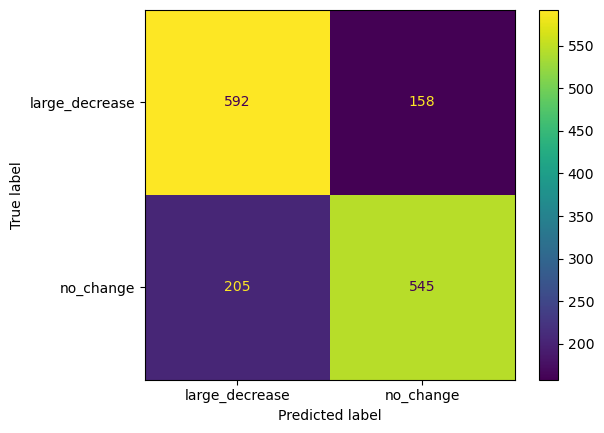

In [49]:
class_names = rf.classes_
print(class_names)

cm = confusion_matrix(y_true = y_test, y_pred = y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = class_names)
disp.plot()

# This is replicable, too. 

# Conventional variable importance

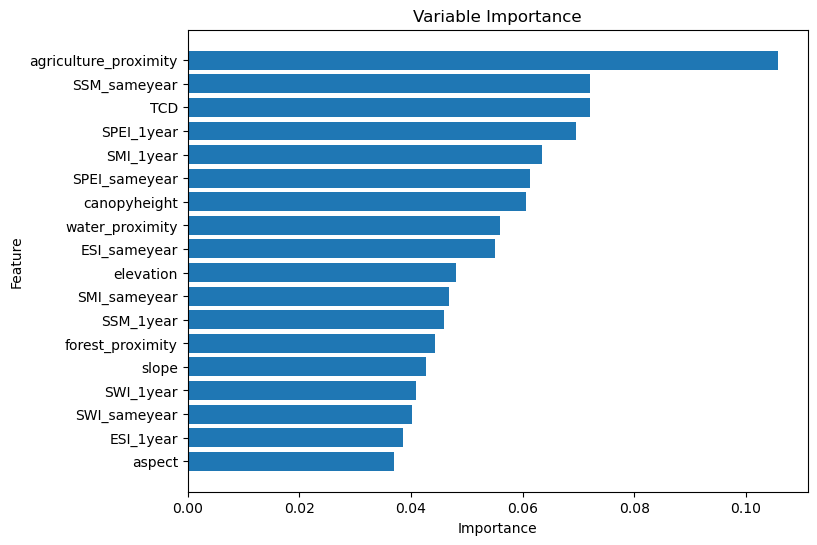

In [50]:
# Get feature importance
importances = rf.feature_importances_

# Create a pandas DataFrame with the feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the DataFrame in ascending order of importance
feature_importances = feature_importances.sort_values('Importance', ascending=True).reset_index(drop=True)

# Plot the variable importance using a bar plot

plt.figure(figsize=(8, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Variable Importance')

# save plot 

plt.savefig("D:/Stenka_Cliwac/Topic_1/12_PYTHON/20230614_shapley/20230614_varImp_classi_exp.png", dpi=300, bbox_inches='tight')
plt.show()


# Time for SHAPley

## Compute SHAP values

In [51]:
explainer = shap.TreeExplainer(rf) 
shap_values = explainer.shap_values(X)

## (A) SHAP Summary Plot — Global Interpretability

A variable importance plot lists the most significant variables in descending order. The top variables contribute more to the model than the bottom ones and thus have high predictive power.

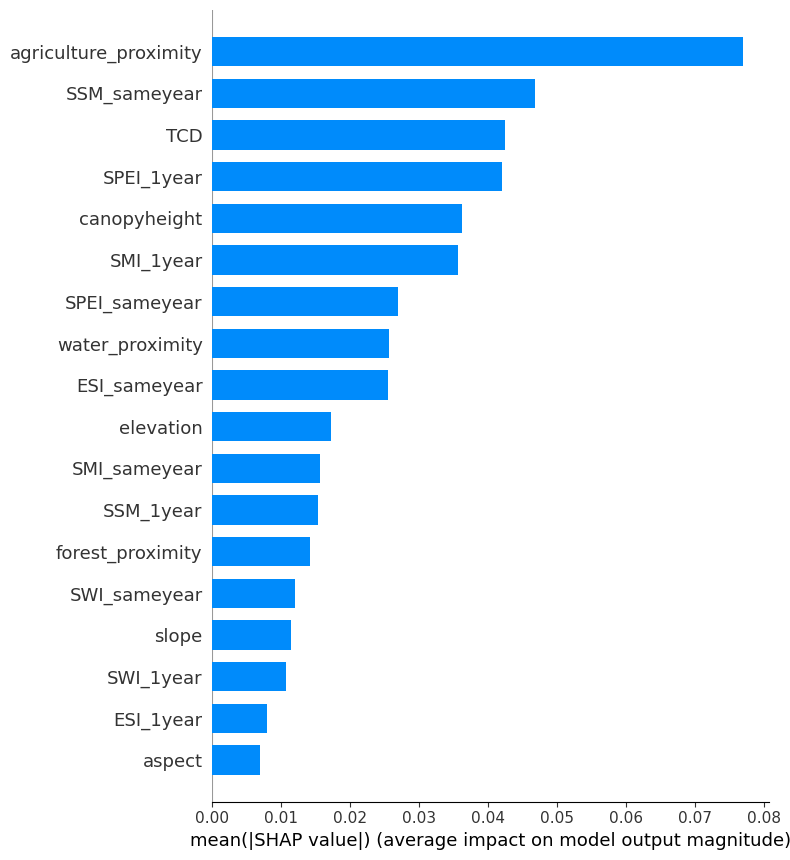

In [55]:
summary_bar_plot = plt.figure()

shap.summary_plot(shap_values[1], X, plot_type="bar")

# save plot
#summary_bar_plot.savefig('D:/Stenka_Cliwac/Topic_1/12_PYTHON/20230614_shapley/20230615_shap_summary_barplot.png', dpi=300, bbox_inches='tight')

The SHAP value plot can show the positive and negative relationships of the predictors with the target variable.

This plot is made of all the dots in the dataset. It delivers the following information:
(1) Feature importance: Variables are ranked in descending order.
(2) Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
(3) Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.

Perhaps 'no change' is on the right side. 
* lower distance to agriculture (closer to ag.) -> decrease in vitality
* lower surface soil moisture (same year) -> decrease in vitality 
* lower SPEI (1 year ago) -> decrease in vitality
* lower canopy height -> decrease in vitality
* lower tree cover density -> decrease in vitality
* lower SMI  (1 year ago) -> decrease in vitality
* lower SPEI (same year) -> ??
* higher distance to water bodies -> decrease in vitality
* lower ESI (same year) -> decrease in vitality
* higher elevation -> decrease in vitality
* lower SSM (1 year ago) -> decrease in vitality
* higher SMI (same year) -> decrease in vitality (does NOT make sense)
* lower SWI (same year) -> decrease in vitality
* lower distance to forest edge (closer to edge of forest) -> decrease in vitality
* lower slope -> decrease in vitality

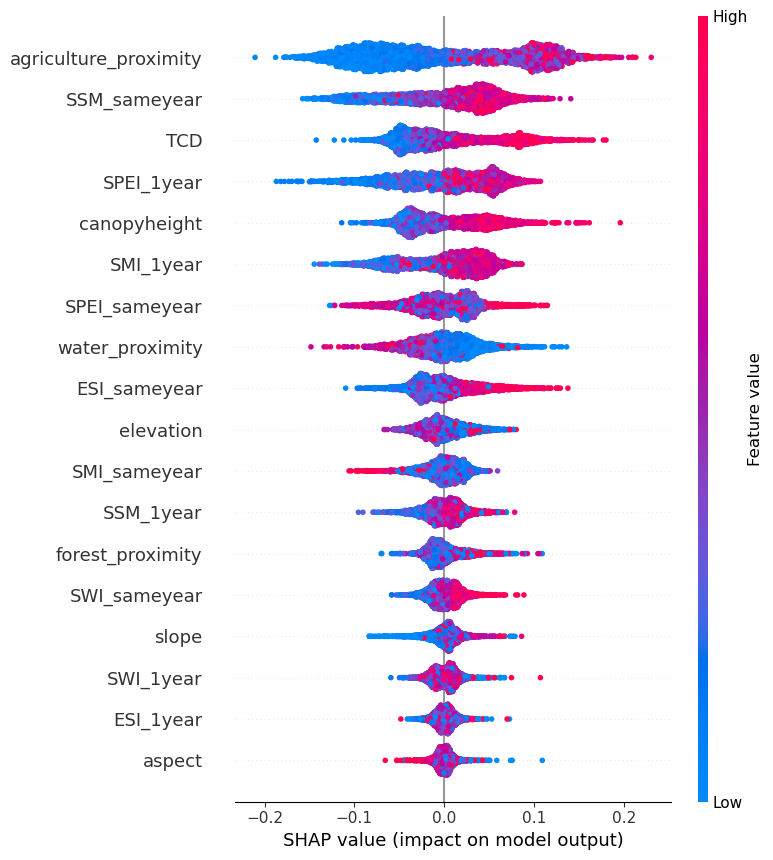

In [54]:
summary_fig = plt.figure()
shap.summary_plot(shap_values[1], X.values, feature_names = X.columns)

# Save the plot as a PNG file
#summary_fig.savefig('D:/Stenka_Cliwac/Topic_1/12_PYTHON/20230614_shapley/shap_summary_plot.png', dpi=300, bbox_inches='tight')

## (B) SHAP Dependence Plot — Global Interpretability

A partial dependence plot shows the marginal effect of one or two features on the predicted outcome of a machine learning model.It tells whether the relationship between the target and a feature is linear, monotonic or more complex.

Each dot is a single prediction (row) from the dataset.
The x-axis is the actual value from the dataset.
The y-axis is the SHAP value for that feature, which represents how much knowing that feature’s value changes the output of the model for that sample’s prediction.
The color corresponds to a second feature that may have an interaction effect with the feature we are plotting (The function automatically includes another variable that your chosen variable interacts most with. If an interaction effect is present between this other feature and the feature we are plotting it will show up as a distinct vertical pattern of coloring.

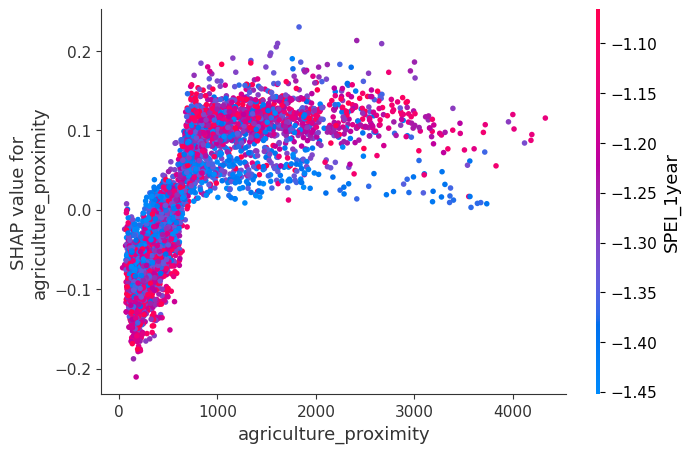

In [63]:
dependence_fig = shap.dependence_plot("agriculture_proximity", shap_values[1], X)

# Display the plot
plt.show()

#dependence_fig.savefig('D:/Stenka_Cliwac/Topic_1/12_PYTHON/20230614_shapley/20230615_shap_dependence_plot.png', dpi=300, bbox_inches='tight')
# saving did not work, no idea why

## (C) Individual SHAP Value Plot — Local Interpretability

Local Interpretability focus on the explainability of a single model prediction.

In [64]:
df.head(10) # raw dataframe I imported

,NDVI_anomaly,agriculture_proximity,aspect,canopyheight,elevation,forest_proximity,slope,TCD,water_proximity,Year_NDVI_anom,...,SMI_sameyear,SPEI_sameyear,SSM_sameyear,SWI_sameyear,ESI_1year,SMI_1year,SPEI_1year,SSM_1year,SWI_1year,NDVI_categories
0,-17.591978,164.387222,194.439835,19.791031,40.227108,95.777023,1.324971,55.104156,709.119873,2019,...,0.090171,-0.756942,52.431690,58.383881,0.542013,0.443343,-1.362994,50.923290,56.462761,large_decrease
1,-12.340168,97.152023,149.787598,17.427414,106.297043,55.577328,2.453972,50.144897,3291.261719,2019,...,0.302668,-0.597577,48.776958,49.246040,0.516985,0.516523,-1.120765,49.822445,51.030510,large_decrease
2,-12.951270,218.536224,166.018326,19.787277,55.517994,65.021805,3.282313,54.848629,1087.705078,2019,...,0.044385,-0.898981,55.998970,52.965813,0.473585,0.356588,-1.215030,51.259060,51.236015,large_decrease
3,-11.686797,126.561951,161.623688,19.958010,50.380432,52.104324,1.616383,57.545586,4615.282715,2019,...,0.125948,-0.831720,45.371521,46.432770,0.503841,0.319622,-1.405387,49.777687,47.937771,large_decrease
4,-10.317186,833.870300,181.626511,22.428598,31.746109,117.354752,0.710619,78.608810,11362.325195,2019,...,0.026165,-0.980845,56.025719,59.088219,0.554641,0.425923,-1.345851,48.450104,57.017765,large_decrease
5,-14.163918,311.598724,182.158310,18.800243,31.836821,114.721977,0.652396,61.781830,8261.359375,2019,...,0.026527,-1.231671,55.629017,46.227077,0.632536,0.345437,-1.399977,44.071159,45.958092,large_decrease
6,-11.102665,273.589172,182.478394,16.567503,57.587456,68.983200,1.348765,61.794914,2509.361328,2019,...,0.054740,-1.060101,53.678234,52.274410,0.568452,0.498870,-1.163585,47.640312,53.762741,large_decrease
7,-13.345599,232.452713,143.795486,22.267006,82.772011,69.996727,0.898930,59.621529,6366.059570,2019,...,0.105355,-0.662786,52.827671,46.748615,0.477868,0.301939,-1.287322,47.186497,47.061810,large_decrease
8,-15.056109,673.165344,179.049332,22.516384,37.165359,64.642578,0.972266,58.456787,261.425720,2019,...,0.076031,-0.673012,62.037678,60.362419,0.611967,0.439541,-1.331829,52.291462,56.636929,large_decrease
9,-10.494026,218.612000,153.995163,22.188158,79.814659,87.656410,3.454529,61.020538,733.370667,2019,...,0.264445,-0.639738,60.696175,53.445347,0.471903,0.534491,-1.104918,49.979973,52.399853,large_decrease


In [65]:
# predictors (X)
# mean of each predictor
X.mean()
# maybe I should normalize these predictors - would that change the results?

agriculture_proximity     714.230136
aspect                    181.024876
canopyheight               21.596236
elevation                  69.932125
forest_proximity          121.595040
slope                       1.949575
TCD                        67.074435
water_proximity          4346.375283
ESI_sameyear                0.552961
SMI_sameyear                0.074649
SPEI_sameyear              -0.765880
SSM_sameyear               57.423716
SWI_sameyear               52.591615
ESI_1year                   0.517055
SMI_1year                   0.380278
SPEI_1year                 -1.274565
SSM_1year                  48.800004
SWI_1year                  50.688518
dtype: float64

### SHAP Force plot

Force plot gives us the explainability of a single model prediction. In this plot, we can see how features contributed to the model’s prediction for a specific observation. It is very convenient to use for error analysis or a deep understanding of a particular case.

In [77]:
print(class_names)

shap.initjs()

i = 66


shap.force_plot(explainer.expected_value[1], shap_values[1][i], X.values[i], feature_names = X.columns)

# SSM is below average --> lower (means large decrease)
# agriculture proximity is low (close to agriculture) --> lower (means large decrease)
# water proximity is low (close to water) --> higher (means no change)

['large_decrease' 'no_change']


The f(x) is the prediction for that observation.

The base value is the value that would be predicted if we didn’t know any features for the current instance. The base value is the average of the model output over the dataset.

The numbers on the plot arrows are the value of the feature for this instance.

Red represents features that pushed the model score higher, and blue representing features that pushed the score lower.

The bigger the arrow, the bigger the impact of the feature on the output. The amount of decrease or increase in the impact can be seen on the x-axis.

In your specific case, where you have two classes ('large_decrease' and 'no_change'), the force plot will show the contribution of each feature for a particular instance and how it influences the predicted output for the positive class ('no_change'). A higher value of a feature will lead to a higher predicted probability or a higher likelihood of belonging to the positive class ('no_change').

Lower surface soil moisture (SSM) (same year) is related to a decrease in vitality. SSM (same year) is 47, which lower than the average value 57. Thus, SSM (same year) pushes the prediction to the left ("large decrease"). As I understand it, a lower overall value leads to classification of "large decrease". A higher value leads to classification of "no change." The threshold is the "base value."

Higher distance to water (water_proximity) leads to lower vitality. Our water_proximity is 1192, which is lower than the average (4346). Thus, the water_proximity pushes the prediction the right ('no_change'), meaning higher vitality.

### Global force plot

If we want more global representation of the previous predictions, we can use a variant of the force plot. Here we can see the predictions for a group of rows placed vertically (rotated of 90°) and side by side. In the below figure we can see the first 10 rows in the dataset.

In [82]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0:10], X[0:10], plot_cmap="DrDb", feature_names=X.columns)

### SHAP waterfall plot

The waterfall plot is another local analysis plot of a single instance prediction.

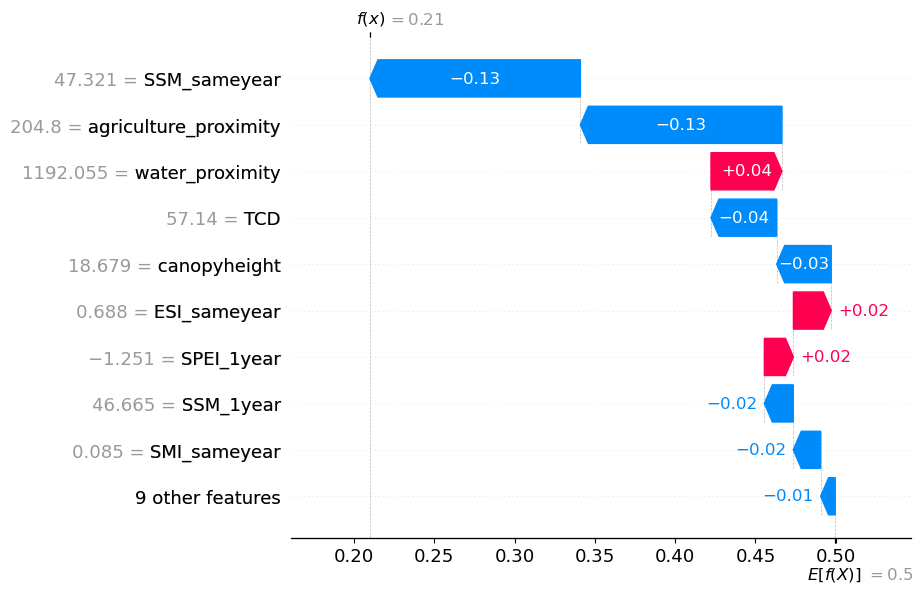

In [83]:
shap.waterfall_plot(shap.Explanation(values=shap_values[1][i], 
                                     base_values=explainer.expected_value[1], 
                                     data=X.iloc[i],  
                                     feature_names=X.columns.tolist()))

The f(x) is the prediction for that observation.

The base value is the value that would be predicted if we didn’t know any features for the current instance. The base value is the average of the model output over the dataset.

The numbers on the plot arrows are the value of the feature for this instance.

Red represents features that pushed the model score higher ("no_change"), and blue representing features that pushed the score lower ("large_decrease").

The bigger the arrow, the bigger the impact of the feature on the output. The amount of decrease or increase in the impact can be seen on the x-axis.

In your specific case, where you have two classes ('large_decrease' and 'no_change'), the force plot will show the contribution of each feature for a particular instance and how it influences the predicted output for the positive class ('no_change'). A higher value of a feature will lead to a higher predicted probability or a higher likelihood of belonging to the positive class ('no_change').

Lower surface soil moisture (SSM) (same year) is related to a decrease in vitality. SSM (same year) is 47, which lower than the average value 57. Thus, SSM (same year) pushes the prediction to the left ("large decrease"). As I understand it, a lower overall value leads to classification of "large decrease". A higher value leads to classification of "no change." The threshold is the "base value."

Higher distance to water (water_proximity) leads to lower vitality. Our water_proximity is 1192, which is lower than the average (4346). Thus, the water_proximity pushes the prediction the right ('no_change'), meaning higher vitality.

### SHAP Decision plot

The Decision Plot shows essentially the same information as the Force Plot and waterfall plot. 
This plot can be a little bit more clear and intuitive than the previous one, especially when there are many features to analyze. 

The decision plot’s straight vertical line marks the model’s base value.Feature values are printed next to the prediction line for reference. 

The colored line is the prediction. If the predicted value is greater than the baseline value, then the line is red; otherwise, it is blue.
Starting at the bottom of the plot, the prediction line shows how the SHAP values accumulate from the base value to arrive at the model’s final score at the top of the plot. 

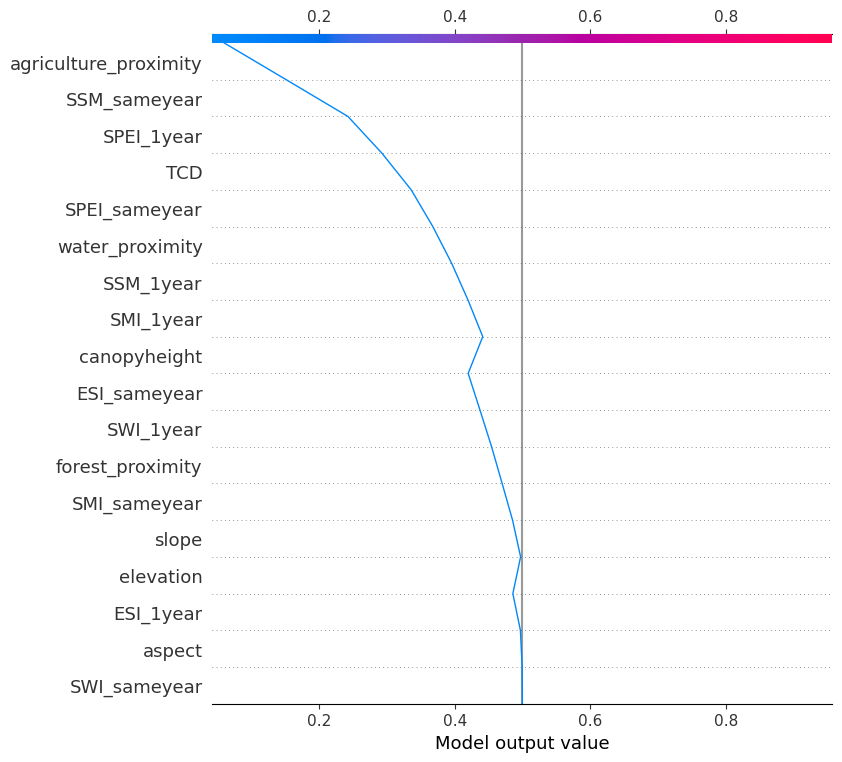

In [88]:
shap.decision_plot(explainer.expected_value[1], shap_values[1][i], feature_names=X.columns.tolist(), show=False)